<a href="https://colab.research.google.com/github/Yanzhi-002/text-analysis-final/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotional Echo Chamber Effects in AI Fear Videos: A Sentiment Time-Series Analysis of YouTube Comments

### final project_yh3942

## 1. Introduction

With the rapid development of generative artificial intelligence (Generative AI), public concern regarding the potential risks of AI has grown significantly. “AI fear videos” have proliferated across social media platforms. These videos often emphasize the dangers of AI—such as “AI will destroy humanity” or “AI is out of control”—and easily trigger strong emotional reactions. As the world’s largest video-based social platform, YouTube serves as an important space where the public expresses anxiety, fear, and uncertainty about AI. However, emotions in comment sections are not static; they change dynamically over the course of discussion and may form an emotional echo chamber in which negative sentiments intensify as the conversation progresses.

## 2. Research Questions

This study focuses on three central questions:

RQ1: Does comment sentiment exhibit upward or downward trends over time?

RQ2: Do early comments (positive/negative) influence subsequent comments (sentiment contagion)?

RQ3: Do AI fear videos exhibit emotional echo chambers dominated by negative sentiment?


## 3. Research Motivation

The rapid advancement of AI has triggered public anxiety about job displacement, governance, safety, deepfakes, and algorithmic control. Emotional content typically spreads faster than rational analysis and shapes the public’s cognitive foundation for policy attitudes. For example, public perceptions of AI regulation, data security, and algorithm oversight are often influenced by fear-based framing.
Analyzing the sentiment dynamics of comment sections under AI fear videos thus helps illuminate the structure of public opinion and the diffusion of emotion in digital public spaces, offering insight for policymakers.


## 4. Data collection

### Selection Criteria

To ensure representativeness, videos were selected under the following criteria:

1. Keyword “AI fear” was used to search videos.

2. The top 60 videos returned by YouTube API (sorted by relevance) were collected.

3. Videos with closed comments were automatically skipped during scraping. Videos with sufficient comment volumes were retained for early/late sentiment analysis.

In total, 60 AI fear–related videos were collected, most containing 200–500 comments, suitable for sentiment time-series analysis.




### Scraping and API Extraction

Data were collected via the YouTube Data API using the search.list, videos.list, and commentThreads.list endpoints, allowing the extraction of video metadata and full comment text with timestamps through a Python pipeline in Google Colab. The following code is adapted from [Krisel 2025](https://github.com/rskrisel/youtube_vader/blob/main/youtube_vader_sentiment_analysis.ipynb).


In [ ]:
# Keep pandas
!pip -q install --upgrade nltk

import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the VADER lexicon (only needs to run once per runtime)
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
!pip -q install requests tqdm

import os
import json
from urllib.parse import urlencode

import requests
import pandas as pd
from tqdm import tqdm

In [ ]:
import os
from getpass import getpass

# Paste your API key when prompted (input will be hidden in Colab)
os.environ["YOUTUBE_API_KEY"] = getpass("Paste your API Key: ")

# Quick sanity check
assert os.environ.get("YOUTUBE_API_KEY"), "API key not set — please run the cell and paste your key."


Paste your API Key: ··········


In [ ]:
# Search AI-fear related videos
API_KEY = os.environ.get("YOUTUBE_API_KEY")
BASE_URL = "https://www.googleapis.com/youtube/v3"

if not API_KEY:
    raise ValueError("Missing API key. Set os.environ['YOUTUBE_API_KEY'] first.")

def yt_get(resource: str, params: dict) -> dict:
    """Call YouTube Data API v3.
    - resource: e.g., 'search', 'videos', 'commentThreads'
    - params: dict of query params (we append the API key here)
    Returns parsed JSON as a Python dict.
    """
    q = {**params, "key": API_KEY}
    url = f"{BASE_URL}/{resource}?{urlencode(q)}"
    r = requests.get(url, timeout=30)
    r.raise_for_status()  # raise an HTTPError if the request failed
    return r.json()

In [ ]:
# Search AI-fear related videos
QUERY = "AI fear"
TARGET_VIDEOS = 60
MAX_RESULTS = 50

video_hits = []
page_token = None

with tqdm(total=TARGET_VIDEOS, desc="Searching videos") as pbar:
    while len(video_hits) < TARGET_VIDEOS:
        # The 'search' resource finds videos; we request snippet data (title, channel, publishedAt).
        params = {
            "part": "snippet",
            "q": QUERY,
            "type": "video",
            "maxResults": MAX_RESULTS,
            "order": "relevance",
        }
        if page_token:
            params["pageToken"] = page_token

        data = yt_get("search", params)
        items = data.get("items", [])

        for it in items:
            vid = it.get("id", {}).get("videoId")
            if not vid:
                continue
            snip = it.get("snippet", {})
            video_hits.append({
                "video_id": vid,
                "publishedAt": snip.get("publishedAt"),
                "title": snip.get("title"),
                "channelId": snip.get("channelId"),
                "channelTitle": snip.get("channelTitle"),
            })
            pbar.update(1)
            if len(video_hits) >= TARGET_VIDEOS:
                break

        page_token = data.get("nextPageToken")
        if not page_token:
            break

videos_df = pd.DataFrame(video_hits)
videos_df.head(3)


Searching videos: 100%|██████████| 60/60 [00:01<00:00, 56.78it/s]


,video_id,publishedAt,title,channelId,channelTitle
0,9fogzZ_6kR0,2024-10-26T20:00:07Z,Is Generative AI an Existential Threat to the ...,UChirEOpgFCupRAk5etXqPaA,Bloomberg News
1,guZ-ZPfjqu0,2025-07-22T18:30:55Z,&quot;This terrifies me&quot; - OpenAI CEO on ...,UCJg9wBPyKMNA5sRDnvzmkdg,LiveNOW from FOX
2,eXdVDhOGqoE,2023-11-06T12:00:37Z,"AI Is Dangerous, but Not for the Reasons You T...",UCAuUUnT6oDeKwE6v1NGQxug,TED


In [ ]:
# Fetch detailed metadata for each video（viewCount / likeCount / commentCount）
def chunked(seq, size):
    for i in range(0, len(seq), size):
        yield seq[i:i+size]


video_ids = videos_df["video_id"].dropna().unique().tolist()
video_details = []

for batch in tqdm(list(chunked(video_ids, 50)), desc="Fetching video details"):
    params = {
        "part": "snippet,statistics",
        "id": ",".join(batch),
        "maxResults": 50,
    }
    data = yt_get("videos", params)
    for it in data.get("items", []):
        snip = it.get("snippet", {})
        stats = it.get("statistics", {})
        video_details.append({
            "video_id": it.get("id"),
            "title": snip.get("title"),
            "description": snip.get("description"),
            "publishedAt": snip.get("publishedAt"),
            "channelTitle": snip.get("channelTitle"),
            "viewCount": int(stats.get("viewCount", 0) or 0),
            "likeCount": int(stats.get("likeCount", 0) or 0),
            "commentCount": int(stats.get("commentCount", 0) or 0),
        })

video_details_df = pd.DataFrame(video_details)
print("Got details for videos:", len(video_details_df))
video_details_df.head(3)

Fetching video details: 100%|██████████| 2/2 [00:00<00:00,  9.01it/s]

Got details for videos: 60


,video_id,title,description,publishedAt,channelTitle,viewCount,likeCount,commentCount
0,9fogzZ_6kR0,Is Generative AI an Existential Threat to the ...,Is generative AI an existential threat to the ...,2024-10-26T20:00:07Z,Bloomberg News,327935,6507,487
1,guZ-ZPfjqu0,"""This terrifies me"" - OpenAI CEO on his 3 grea...",OpenAI CEO Sam Altman discusses his biggest wo...,2025-07-22T18:30:55Z,LiveNOW from FOX,187835,1424,464
2,eXdVDhOGqoE,"AI Is Dangerous, but Not for the Reasons You T...",AI won't kill us all — but that doesn't make i...,2023-11-06T12:00:37Z,TED,1753453,31869,2682


In [ ]:
# Fetch comments for each video (including timestamp & text)
all_comments = []

for vid in tqdm(video_details_df["video_id"].tolist(), desc="Fetching comments"):
    page_token = None
    fetched = 0
    try:
        while True:
            params = {
                "part": "snippet",
                "videoId": vid,
                "maxResults": 100,
                "order": "time",
            }
            if page_token:
                params["pageToken"] = page_token

            data = yt_get("commentThreads", params)
            items = data.get("items", [])

            if not items:
                break

            for it in items:
                top = it.get("snippet", {}).get("topLevelComment", {})
                s = top.get("snippet", {})
                all_comments.append({
                    "video_id": vid,
                    "comment_id": top.get("id"),
                    "author": s.get("authorDisplayName"),
                    "publishedAt": s.get("publishedAt"),
                    "likeCount": s.get("likeCount", 0),
                    "text": s.get("textOriginal", ""),
                })
                fetched += 1

            page_token = data.get("nextPageToken")
            if not page_token:
                break


            if fetched >= 500:
                break

    except requests.HTTPError as e:
        print(f"Skipping {vid} due to HTTP error: {e}")
        continue

comments_df = pd.DataFrame(all_comments)
print("Total comments fetched:", len(comments_df))
comments_df.head(3)

Fetching comments: 100%|██████████| 60/60 [00:30<00:00,  1.97it/s]

Total comments fetched: 15493


,video_id,comment_id,author,publishedAt,likeCount,text
0,9fogzZ_6kR0,UgwCnyX7eQ_55rpxxOB4AaABAg,@shashank...853,2025-11-26T17:18:12Z,0,"Should take his words seriously, as he is the ..."
1,9fogzZ_6kR0,Ugzp_k1JX1eTxJJuGlF4AaABAg,@robustbottlecap,2025-11-25T21:31:25Z,1,i suspect somehow people are propping up the t...
2,9fogzZ_6kR0,UgzWu_-ApChgxnL_R5B4AaABAg,@Universalwisdomknowledge,2025-11-25T11:13:06Z,0,The striking advantage of a cybernetic organis...


## 5. Research Methods

### Data Cleaning

Because VADER is sensitive to punctuation, emojis, and capitalization, a lightweight cleaning approach was used:

1. Removing URLs

2. Removing HTML encodings (e.g., &nbsp;)

3. Removing redundant whitespace

4. Preserving emojis, exclamation marks, and capitalization

The cleaned text was stored in text_clean for sentiment scoring.


In [ ]:
# Lightly clean the comment text and compute sentiment scores (compound) using VADER
import re
def clean_comment(text):
    """Light cleaning without removing features important for VADER"""
    if not isinstance(text, str):
        return ""
    text = text.strip()
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"&\w+;", "", text)
    return text

comments_df["text_clean"] = comments_df["text"].apply(clean_comment)

def compound_score(text: str) -> float:
    return sia.polarity_scores(text or "")["compound"]

comments_df["compound"] = comments_df["text_clean"].apply(compound_score)

# Convert the timestamp to datetime
comments_df["publishedAt"] = pd.to_datetime(comments_df["publishedAt"])

comments_df.head(3)

,video_id,comment_id,author,publishedAt,likeCount,text,text_clean,compound
0,9fogzZ_6kR0,UgwCnyX7eQ_55rpxxOB4AaABAg,@shashank...853,2025-11-26 17:18:12+00:00,0,"Should take his words seriously, as he is the ...","Should take his words seriously, as he is the ...",-0.1779
1,9fogzZ_6kR0,Ugzp_k1JX1eTxJJuGlF4AaABAg,@robustbottlecap,2025-11-25 21:31:25+00:00,1,i suspect somehow people are propping up the t...,i suspect somehow people are propping up the t...,-0.6597
2,9fogzZ_6kR0,UgzWu_-ApChgxnL_R5B4AaABAg,@Universalwisdomknowledge,2025-11-25 11:13:06+00:00,0,The striking advantage of a cybernetic organis...,The striking advantage of a cybernetic organis...,-0.9492


### Data Processing


Processing steps include:

1. Grouping comments by video

2. Sorting comments by publishedAt

3. Assigning each comment an order_in_video index (1 to N)

This enabled time-series visualization and early/late comparison.


### Sentiment Analysis

Sentiment scores were computed using VADER (NLTK).

Additionally, the following were calculated:

1. Mean sentiment of the first 50 comments (early_mean)
2. Mean sentiment of the last 50 comments (late_mean)

Sentiment difference (delta_late_minus_early), used to assess echo chamber intensity


In [ ]:
# Sort the data by time, add an index, and construct a sentiment time series
comments_df = comments_df.sort_values(["video_id", "publishedAt"]).reset_index(drop=True)

comments_df["order_in_video"] = comments_df.groupby("video_id").cumcount() + 1
example_vid = comments_df["video_id"].iloc[0]
comments_df[comments_df["video_id"] == example_vid].head(5)

,video_id,comment_id,author,publishedAt,likeCount,text,text_clean,compound,order_in_video
0,-KTHnRgKHSM,Ugz0uQKrwsgVjsEMp9x4AaABAg,@rlak5,2025-06-11 16:16:18+00:00,1,I'm from Bangladesh🇧🇩,I'm from Bangladesh🇧🇩,0.0000,1
1,-KTHnRgKHSM,Ugyl-z8Lu71kg1Dw0BJ4AaABAg,@prakharsingh8766,2025-06-11 16:28:05+00:00,1,These Ted talks are real gold.they have the po...,These Ted talks are real gold.they have the po...,0.0772,2
2,-KTHnRgKHSM,UgxFyYiW_kJ141ioyYV4AaABAg,@theprojectblythe,2025-06-11 16:59:38+00:00,0,I'm commenting on the first 23 secs of this vi...,I'm commenting on the first 23 secs of this vi...,0.9433,3
3,-KTHnRgKHSM,Ugx9U3sjvi06hyoIpvR4AaABAg,@ulrichassouto,2025-06-11 22:03:32+00:00,0,"Everybody is scared of AI. As I’m concerned, w...","Everybody is scared of AI. As I’m concerned, w...",-0.6656,4
4,-KTHnRgKHSM,UgzoF6GcXMuN0wLIfqp4AaABAg,@deborahann9474,2025-06-12 02:27:04+00:00,1,Not dying does not mean eternal life.,Not dying does not mean eternal life.,0.0000,5


In [ ]:
# Sentiment echo-chamber analysis: comparing early vs. late sentiment
def early_late_stats(df, k=50):

    results = []
    for vid, sub in df.groupby("video_id"):
        sub = sub.sort_values("order_in_video")
        n = len(sub)
        if n < 2 * k:

            continue

        early = sub.iloc[:k]
        late = sub.iloc[-k:]

        results.append({
            "video_id": vid,
            "title": video_details_df.set_index("video_id").loc[vid, "title"]
                     if vid in video_details_df["video_id"].values else None,
            "n_comments": n,
            "early_mean": early["compound"].mean(),
            "late_mean": late["compound"].mean(),
            "delta_late_minus_early": late["compound"].mean() - early["compound"].mean(),
        })
    return pd.DataFrame(results)


echo_stats = early_late_stats(comments_df, k=50)
echo_stats.sort_values("delta_late_minus_early").head(60)

,video_id,title,n_comments,early_mean,late_mean,delta_late_minus_early
16,PaOLBOuyswI,Building the AI of F.E.A.R. with Goal Oriented...,114,0.314042,0.041600,-0.272442
26,dXtwro68GiQ,"If You’re Creative But Scared About AI, Watch ...",238,0.408542,0.188746,-0.219796
7,GJeFoEw9x0M,AI CEO explains the terrifying new behavior AI...,500,0.012224,-0.165544,-0.177768
35,ySqPKEfBFvY,AI is getting scary 😱 #ai,500,0.073746,-0.079216,-0.152962
6,EoJ6gXGL-zM,AI expert reveals his 'single greatest fear' a...,500,-0.030168,-0.165852,-0.135684
17,T2g8FF8-RLA,Sam Altman on AGI: people will freak out then ...,500,0.106636,-0.026834,-0.133470
31,qe9QSCF-d88,The Catastrophic Risks of AI — and a Safer Pat...,500,0.144154,0.026274,-0.117880
14,OG57rWI7o4o,AI boom or bubble? why economists fear a globa...,387,0.135024,0.024218,-0.110806
8,HKMb_TXvyZg,You Have No Idea How Terrified AI Scientists A...,500,0.087452,-0.011334,-0.098786
9,Hq3TtNRc0Fs,Fear and Loathing in the Age of AI,500,0.253710,0.167952,-0.085758


### Results Visualization


Two visualization types were employed:
1. Early vs. Late Sentiment Comparison Table. （in the previous step's code）

The table includes: early_mean, late_mean, delta

This allows systematic cross-video evaluation of emotional echo chambers.

2. Sentiment Time Series for Individual Videos

* Blue line: sentiment per comment
* Red line: rolling average (window = 20)

These trends reveal emotional trajectories and clustering patterns.


In [ ]:
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "colab"  # Make sure it displays properly in Colab

/usr/local/lib/python3.12/dist-packages/kaleido/_sync_server.py:11: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




In [ ]:
# Visualization — sentiment line chart & rolling average
if not echo_stats.empty:

    target_video_id = echo_stats.sort_values("n_comments", ascending=False)["video_id"].iloc[0]
else:

    target_video_id = comments_df["video_id"].value_counts().index[0]

print("Target video for visualization:", target_video_id)

target_title = video_details_df.set_index("video_id").loc[target_video_id, "title"] \
    if target_video_id in video_details_df["video_id"].values else target_video_id

target_comments = comments_df[comments_df["video_id"] == target_video_id].copy()
target_comments = target_comments.sort_values("order_in_video")

WINDOW = 20
target_comments["rolling_mean"] = (
    target_comments["compound"]
    .rolling(window=WINDOW, min_periods=1)
    .mean()
)

print("Number of comments in target video:", len(target_comments))
target_comments.head(5)


fig = px.line(
    target_comments,
    x="order_in_video",
    y="compound",
    title=f"Sentiment over time for one AI fear video\n{target_title[:80]}",
    labels={"order_in_video": "Comment order (time)", "compound": "VADER compound sentiment"},
)


fig.add_scatter(
    x=target_comments["order_in_video"],
    y=target_comments["rolling_mean"],
    mode="lines",
    name=f"Rolling mean (window={WINDOW})"
)

fig.show()

fig.write_html("ai_fear_sentiment_timeseries.html", include_plotlyjs="cdn", full_html=True)
fig.write_image("ai_fear_sentiment_timeseries.png")




Target video for visualization: 7wfAcn9BJ9I
Number of comments in target video: 500


ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


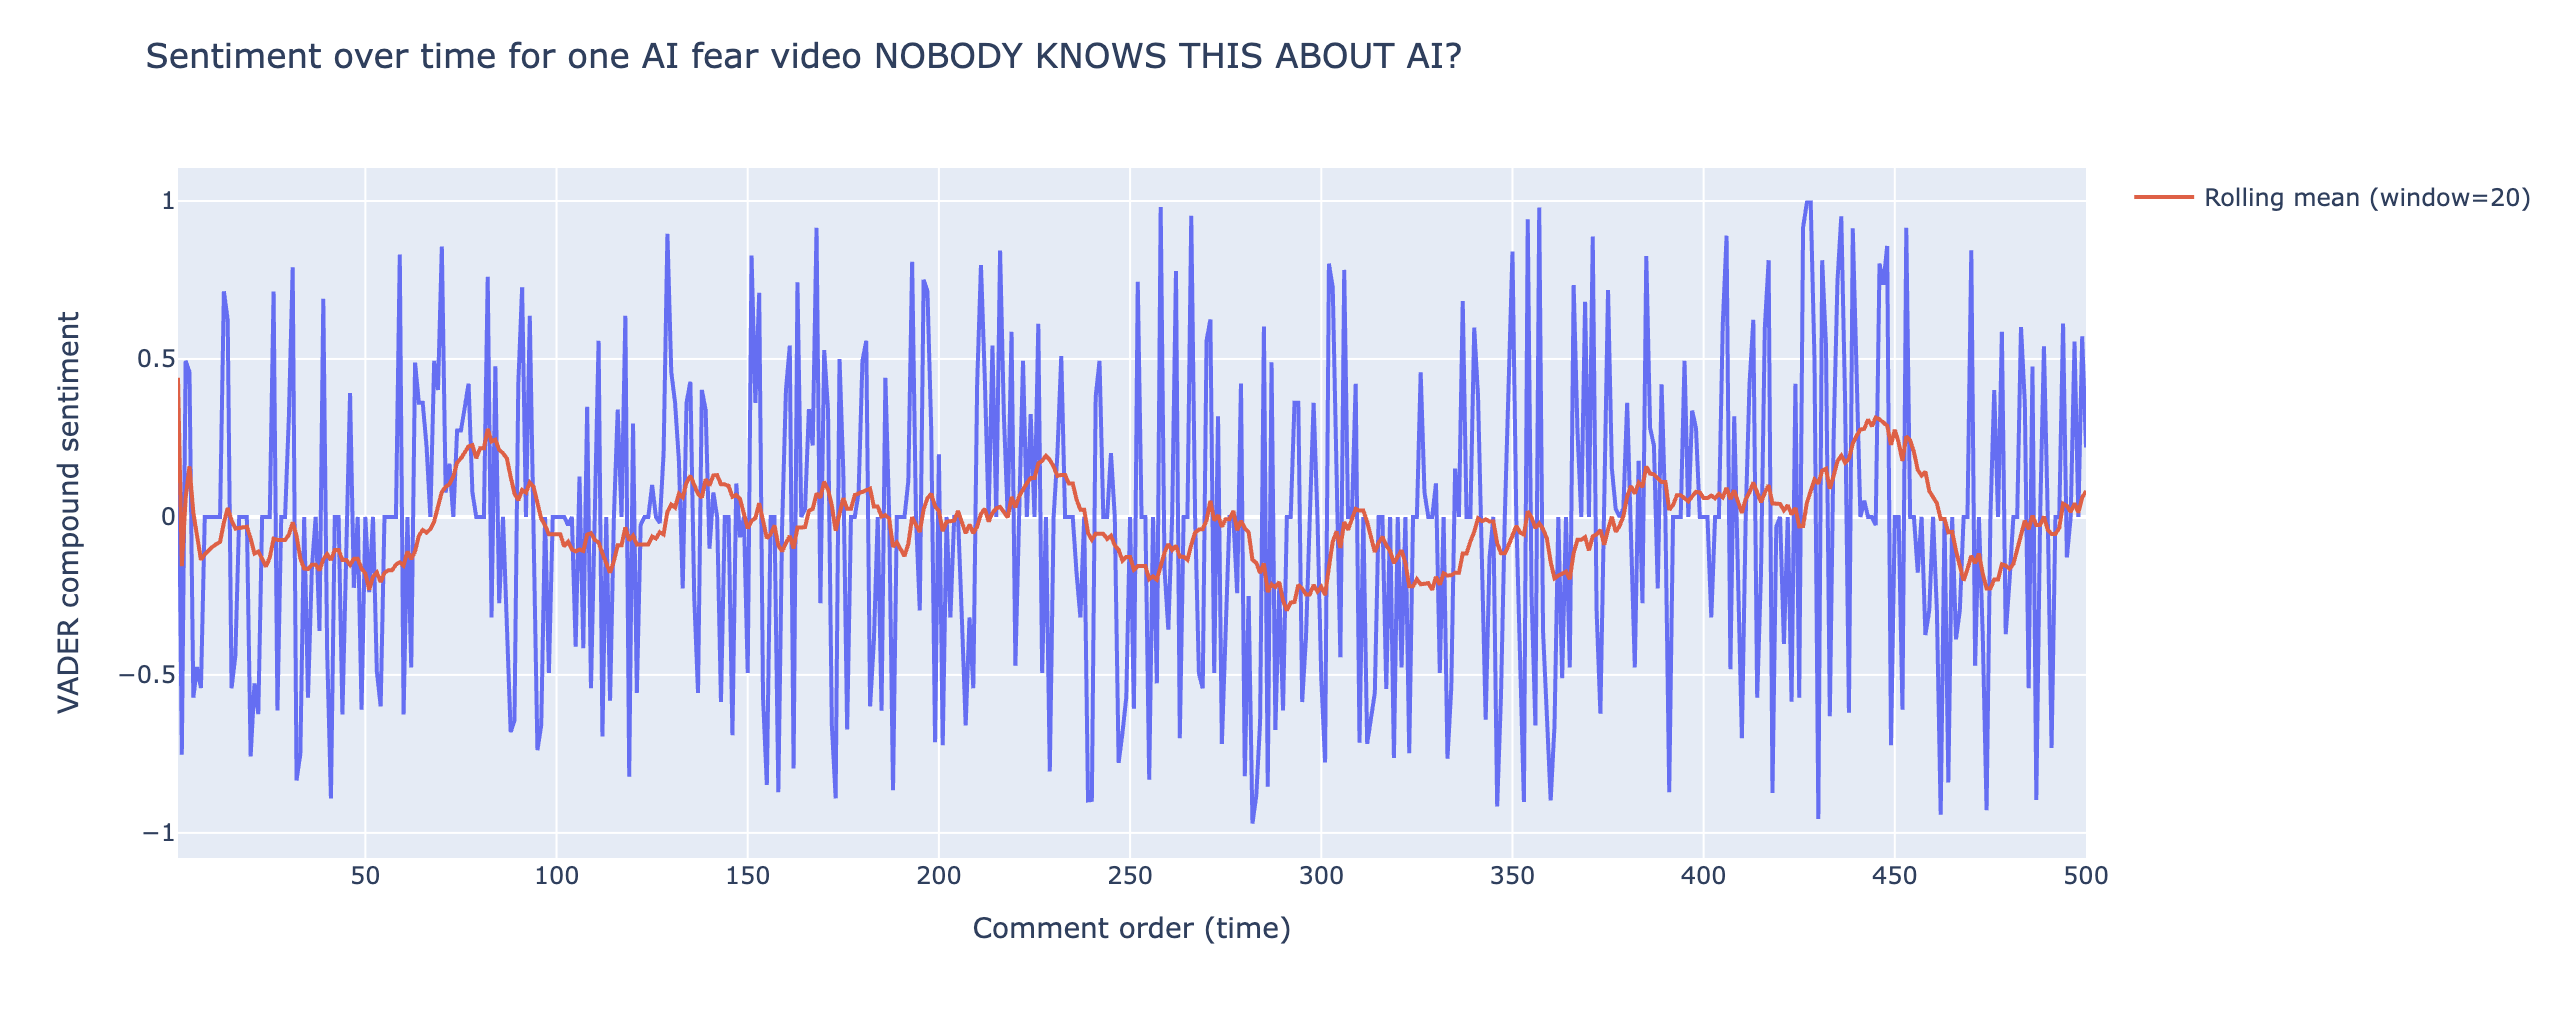

In [ ]:
# Save the results in Google Drive

from google.colab import drive
import os

drive.mount("/content/drive")

save_dir = "/content/drive/MyDrive/Final_Project_vader"
os.makedirs(save_dir, exist_ok=True)

video_details_path = os.path.join(save_dir, "video_details.csv")
comments_path = os.path.join(save_dir, "video_comments_with_sentiment.csv")
echo_stats_path = os.path.join(save_dir, "ai_fear_echo_stats.csv")

video_details_df.to_csv(video_details_path, index=False)
comments_df.to_csv(comments_path, index=False)
echo_stats.to_csv(echo_stats_path, index=False)

print("Form saved：")
print(" -", video_details_path)
print(" -", comments_path)
print(" -", echo_stats_path)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Form saved：
 - /content/drive/MyDrive/Final_Project_vader/video_details.csv
 - /content/drive/MyDrive/Final_Project_vader/video_comments_with_sentiment.csv
 - /content/drive/MyDrive/Final_Project_vader/ai_fear_echo_stats.csv


## 6. Findings


#### 1. RQ1: Do sentiments trend over time?

Analysis reveals that the sentiment of comments on AI fear videos exhibits significant dynamic shifts over time. The time-series chart for a single video shows the rolling mean consistently remaining negative between comments 200–350, forming a distinct “negative sentiment trough.” Concurrently, the amplitude of later sentiment fluctuations markedly increases, indicating a progressively more polarized discussion atmosphere. This represents not merely random noise but a directional shift in sentiment.
After comment 350, the rolling mean gradually recovers toward neutral territory, suggesting that new user groups may have joined the discussion later, moderating the overall sentiment. This structural pattern of “decline-trough-rebound” indicates that sentiment in the AI fear video comment section is neither stable nor chaotic, but rather exhibits phased clustering and a distinct negative drift over time.

#### 2. RQ2: Do early sentiments influence later comments?

Across videos, early_mean values are often neutral or mildly positive. However, late_mean values are consistently more negative. This indicates that early sentiment does not directly dictate later sentiment but that the atmosphere formed by early discussion influences subsequent expression. Negative emotions accumulate over time, demonstrating noticeable sentiment contagion.

#### 3. RQ3: Does a negative emotional echo chamber exist?

Most videos exhibit negative delta_late_minus_early values (e.g., –0.27, –0.21, –0.15). This indicates that late-stage comments are significantly more negative than early-stage comments and that negativity increases over time. This pattern matches the definition of an emotional echo chamber: negative sentiment becomes amplified through interaction, creating a collectively negative emotional environment. The results provide systematic quantitative evidence of negative sentiment echo chambers in AI fear discussions.


## 7. Conclusion

This study finds that comment sections under AI fear videos display pronounced negative emotional echo chambers: sentiment declines over time, late comments are substantially more negative than early ones, and emotional contagion and clustering occur structurally. This suggests that public attitudes toward AI risks are shaped not purely by rational evaluation but also by iterative emotional reinforcement in social interactions.

These findings have direct implications for AI policy.
* Accumulating negative sentiment may influence public support for AI regulation, model oversight, and data security measures, making policy discussions more susceptible to fear-driven narratives.
* Platform algorithms may unintentionally amplify fear content, shaping public risk perception and discouraging balanced understanding of AI capabilities.
* Additionally, because sentiment evolves over time, policymakers should monitor emotional dynamics rather than rely solely on one-time opinion polling. Interventions such as official explanations, information panels, or pinned comments could help maintain a more balanced public dialogue.


## 8. Next Step

Future research could expand in the following directions:
* Cross-topic comparison: Compare AI fear sentiment structures with those in gun control, immigration, or climate fear videos.
* Intervention experiments: Examine whether pinned comments or official explanations can mitigate negative sentiment diffusion.